In [1]:
ages={"0-10":0,"10-20":1,"20-30":2,"30-40":3,"40-50":4,"50-60":5,"60-70":6,"70-80":7,"80+":8}

In [2]:
ages.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [3]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import os



In [4]:
from dataclasses import dataclass

In [5]:
@dataclass
class row:
  window_id:int
  location:str
  age_grp:int
  symptom:str




In [6]:
np.random.seed(7)
random.seed(7)

In [7]:
locations=["hyd","blr","del","che","mumb","bbsr","noi"]


In [8]:
symptoms=["cold","cough","fever","acidity","asthma","fatigue"]

In [9]:
alph=np.ones(len(symptoms))
alph

array([1., 1., 1., 1., 1., 1.])

In [10]:
weights=np.random.dirichlet(alpha=alph)
weights

array([0.00986657, 0.18816057, 0.07171899, 0.15977784, 0.47435909,
       0.09611694])

In [11]:
k=np.random.randint(1,len(symptoms)//2 + 1)

In [12]:
biased_idx=np.random.choice(len(symptoms),k,replace=False)
biased_idx_list=biased_idx.tolist()
biased_idx_set=set(biased_idx_list)

In [13]:
bias=np.random.randint(5,11)
bias

9

In [14]:
all_idx=np.arange(0,len(symptoms))
all_idx_list=all_idx.tolist()
all_idx_set=set(all_idx_list)
unbiased_set=all_idx_set-biased_idx_set
unbiased_list=list(unbiased_set)
unbiased_list


[0, 1, 2, 4, 5]

In [15]:
unbiased_idx=np.array(unbiased_list)
unbiased_idx

array([0, 1, 2, 4, 5])

In [16]:
alph[biased_idx_list]+=bias

alph = np.clip(alph, a_min=1, a_max=None)
alph_t=alph.copy()

In [17]:
rows=[]

In [18]:
weights=np.random.dirichlet(alpha=alph)
weights

array([0.10228794, 0.02023208, 0.02513739, 0.69737043, 0.02138414,
       0.13358803])

In [19]:
# -------------------------
# CONFIG
# -------------------------
TOTAL_WINDOWS = 200
NORMAL_MIN, NORMAL_MAX = 100, 300
OUTBREAK_MIN, OUTBREAK_MAX = 1500, 1700
NORMAL_COOLDOWN = 48
OUTBREAK_DURATION = 32
OUTBREAK_TRIGGER_PROB = 0.3

# -------------------------
# STATE INITIALIZATION
# -------------------------
state = "normal"
normal_counter = 0
outbreak_counter = 0
rows = []

# -------------------------
# MAIN LOOP
# -------------------------
for window_id in range(TOTAL_WINDOWS):

    # 1. ALWAYS generate background noise
    n_normal = np.random.randint(NORMAL_MIN, NORMAL_MAX)

    for _ in range(n_normal):
        rows.append(row(
            window_id,
            np.random.choice(locations),
            np.random.randint(0, 9),
            np.random.choice(symptoms, p=weights)
        ))

    # -------------------------
    # 2. UPDATE DYNAMICS (ONLY IN NORMAL STATE)
    # -------------------------
    if state == "normal":

        bias_dy = np.random.randint(2, 11)
        alph *= 0.95
        alph[biased_idx_list] += bias_dy
        alph = np.clip(alph, 1.0, None)
        weights = np.random.dirichlet(alpha=alph)

        biased_idx_set = set(biased_idx_list)
        unbiased_idx = list(set(range(len(symptoms))) - biased_idx_set)

        if np.random.rand() <= 0.3 and len(unbiased_idx) > 0:
            biased_idx_list.append(np.random.choice(unbiased_idx))

        if np.random.rand() <= 0.3 and len(biased_idx_list) > 1:
            biased_idx_list.pop(0)

    # -------------------------
    # 3. STATE MACHINE
    # -------------------------
    if state == "normal":
        normal_counter += 1

        # Transition to outbreak
        if normal_counter >= NORMAL_COOLDOWN and np.random.rand() < OUTBREAK_TRIGGER_PROB:
            state = "outbreak"
            normal_counter = 0
            outbreak_counter = 0

            # -------------------------
            # LOCK OUTBREAK IDENTITY
            # -------------------------
            outbreak_location = locations[0]

            # pick MOST DOMINANT symptom from last normal window
            outbreak_symptom_idx = int(np.argmax(alph))
            outbreak_symptom = symptoms[outbreak_symptom_idx]

            outbreak_age = np.random.choice([0, 1, 8])

    elif state == "outbreak":

        # Generate outbreak entries
        n_outbreak = np.random.randint(OUTBREAK_MIN, OUTBREAK_MAX)

        for _ in range(n_outbreak):
            rows.append(row(
                window_id,
                outbreak_location,
                outbreak_age,
                outbreak_symptom
            ))

        outbreak_counter += 1

        # Transition back to normal
        if outbreak_counter >= OUTBREAK_DURATION:
            state = "normal"
            outbreak_counter = 0


In [20]:
rows

[row(window_id=0, location=np.str_('bbsr'), age_grp=0, symptom=np.str_('acidity')),
 row(window_id=0, location=np.str_('hyd'), age_grp=2, symptom=np.str_('acidity')),
 row(window_id=0, location=np.str_('noi'), age_grp=6, symptom=np.str_('fatigue')),
 row(window_id=0, location=np.str_('blr'), age_grp=7, symptom=np.str_('acidity')),
 row(window_id=0, location=np.str_('hyd'), age_grp=3, symptom=np.str_('acidity')),
 row(window_id=0, location=np.str_('hyd'), age_grp=0, symptom=np.str_('acidity')),
 row(window_id=0, location=np.str_('bbsr'), age_grp=7, symptom=np.str_('acidity')),
 row(window_id=0, location=np.str_('blr'), age_grp=3, symptom=np.str_('acidity')),
 row(window_id=0, location=np.str_('mumb'), age_grp=7, symptom=np.str_('fever')),
 row(window_id=0, location=np.str_('mumb'), age_grp=3, symptom=np.str_('acidity')),
 row(window_id=0, location=np.str_('che'), age_grp=1, symptom=np.str_('acidity')),
 row(window_id=0, location=np.str_('mumb'), age_grp=3, symptom=np.str_('acidity')),
 

In [21]:
from dataclasses import asdict

In [22]:
dict_list=[asdict(r) for r in rows]
dict_list

[{'window_id': 0,
  'location': np.str_('bbsr'),
  'age_grp': 0,
  'symptom': np.str_('acidity')},
 {'window_id': 0,
  'location': np.str_('hyd'),
  'age_grp': 2,
  'symptom': np.str_('acidity')},
 {'window_id': 0,
  'location': np.str_('noi'),
  'age_grp': 6,
  'symptom': np.str_('fatigue')},
 {'window_id': 0,
  'location': np.str_('blr'),
  'age_grp': 7,
  'symptom': np.str_('acidity')},
 {'window_id': 0,
  'location': np.str_('hyd'),
  'age_grp': 3,
  'symptom': np.str_('acidity')},
 {'window_id': 0,
  'location': np.str_('hyd'),
  'age_grp': 0,
  'symptom': np.str_('acidity')},
 {'window_id': 0,
  'location': np.str_('bbsr'),
  'age_grp': 7,
  'symptom': np.str_('acidity')},
 {'window_id': 0,
  'location': np.str_('blr'),
  'age_grp': 3,
  'symptom': np.str_('acidity')},
 {'window_id': 0,
  'location': np.str_('mumb'),
  'age_grp': 7,
  'symptom': np.str_('fever')},
 {'window_id': 0,
  'location': np.str_('mumb'),
  'age_grp': 3,
  'symptom': np.str_('acidity')},
 {'window_id': 0,


In [23]:
raw_df=pd.DataFrame.from_dict(dict_list)
raw_df.head()

,window_id,location,age_grp,symptom
0,0,bbsr,0,acidity
1,0,hyd,2,acidity
2,0,noi,6,fatigue
3,0,blr,7,acidity
4,0,hyd,3,acidity


In [24]:
raw_df.dtypes

,0
window_id,int64
location,object
age_grp,int64
symptom,object


In [25]:
raw_df = raw_df.sort_values("window_id").reset_index(drop=True)

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142606 entries, 0 to 142605
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   window_id  142606 non-null  int64 
 1   location   142606 non-null  object
 2   age_grp    142606 non-null  int64 
 3   symptom    142606 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.4+ MB


In [26]:
raw_df2=raw_df.copy()

In [27]:
observed={}

In [28]:
l={"fg":1}

In [29]:
l['fg']+=1

In [30]:
agg_df = (
  raw_df2
  .groupby(["window_id", "location", "symptom"])
  .size()
  .reset_index(name="count")
  .sort_values("window_id")
  .reset_index(drop=True)
)

In [31]:
agg_df.head(
)

,window_id,location,symptom,count
0,0,che,cold,1
1,0,mumb,fatigue,6
2,0,mumb,fever,1
3,0,noi,acidity,26
4,0,noi,asthma,1


In [32]:
agg_df["mean_3hr"]=agg_df.groupby(["location","symptom"],group_keys=False)["count"].transform(lambda j:j.rolling(window=3).mean())

In [33]:
agg_df

,window_id,location,symptom,count,mean_3hr
0,0,che,cold,1,NaN
1,0,mumb,fatigue,6,NaN
2,0,mumb,fever,1,NaN
3,0,noi,acidity,26,NaN
4,0,noi,asthma,1,NaN
...,...,...,...,...,...
7640,199,noi,cough,8,4.333333
7641,199,noi,fatigue,15,8.333333
7642,199,noi,fever,5,5.333333
7643,199,blr,cough,5,4.333333


In [34]:
agg_df2=agg_df.copy()

In [35]:
agg_df2=agg_df2.sort_values(["window_id"]).reset_index(drop=True)

In [36]:
agg_df2["mean_day"]=agg_df2.groupby(["location","symptom"])["count"].transform(lambda k:k.rolling(window=24).mean())

In [37]:
agg_df2

,window_id,location,symptom,count,mean_3hr,mean_day
0,0,bbsr,cold,3,NaN,NaN
1,0,del,cough,1,NaN,NaN
2,0,del,fatigue,6,NaN,NaN
3,0,del,fever,2,NaN,NaN
4,0,hyd,acidity,32,NaN,NaN
...,...,...,...,...,...,...
7640,199,noi,fever,5,5.333333,5.250000
7641,199,blr,cough,5,4.333333,2.833333
7642,199,bbsr,fatigue,15,9.666667,12.875000
7643,199,hyd,asthma,1,1.666667,2.541667


In [38]:
agg_df2["std_3hr"]=agg_df2.groupby(["location","symptom"])["count"].transform(lambda k:k.rolling(window=24).std())

In [39]:
agg_df2

,window_id,location,symptom,count,mean_3hr,mean_day,std_3hr
0,0,bbsr,cold,3,NaN,NaN,NaN
1,0,del,cough,1,NaN,NaN,NaN
2,0,del,fatigue,6,NaN,NaN,NaN
3,0,del,fever,2,NaN,NaN,NaN
4,0,hyd,acidity,32,NaN,NaN,NaN
...,...,...,...,...,...,...,...
7640,199,noi,fever,5,5.333333,5.250000,3.206651
7641,199,blr,cough,5,4.333333,2.833333,1.857222
7642,199,bbsr,fatigue,15,9.666667,12.875000,5.227956
7643,199,hyd,asthma,1,1.666667,2.541667,1.413573


In [40]:
agg_df2["std_day"]=agg_df2.groupby(["location","symptom"])["count"].transform(lambda k:k.rolling(window=24).std())

In [41]:
agg_df2

,window_id,location,symptom,count,mean_3hr,mean_day,std_3hr,std_day
0,0,bbsr,cold,3,NaN,NaN,NaN,NaN
1,0,del,cough,1,NaN,NaN,NaN,NaN
2,0,del,fatigue,6,NaN,NaN,NaN,NaN
3,0,del,fever,2,NaN,NaN,NaN,NaN
4,0,hyd,acidity,32,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
7640,199,noi,fever,5,5.333333,5.250000,3.206651,3.206651
7641,199,blr,cough,5,4.333333,2.833333,1.857222,1.857222
7642,199,bbsr,fatigue,15,9.666667,12.875000,5.227956,5.227956
7643,199,hyd,asthma,1,1.666667,2.541667,1.413573,1.413573


In [42]:
agg_df3=agg_df2.copy()

In [43]:
dif=agg_df3["mean_3hr"]-agg_df3["mean_day"]

agg_df3["z_score"]=np.where(
  (dif>0)&(agg_df3["std_day"]>0),
  dif/agg_df3["std_day"],
  0
)

In [44]:
agg_df3["z_score"].max()

2.589834065296883

In [45]:
agg_df3

,window_id,location,symptom,count,mean_3hr,mean_day,std_3hr,std_day,z_score
0,0,bbsr,cold,3,NaN,NaN,NaN,NaN,0.000000
1,0,del,cough,1,NaN,NaN,NaN,NaN,0.000000
2,0,del,fatigue,6,NaN,NaN,NaN,NaN,0.000000
3,0,del,fever,2,NaN,NaN,NaN,NaN,0.000000
4,0,hyd,acidity,32,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...
7640,199,noi,fever,5,5.333333,5.250000,3.206651,3.206651,0.025988
7641,199,blr,cough,5,4.333333,2.833333,1.857222,1.857222,0.807658
7642,199,bbsr,fatigue,15,9.666667,12.875000,5.227956,5.227956,0.000000
7643,199,hyd,asthma,1,1.666667,2.541667,1.413573,1.413573,0.000000


In [46]:

k = 0.75  # min z-score val considered in cusum
h = 3.0  # threshold val for cusum

agg_df3['cusum'] = 0.0

# We need to loop because CUSUM relies on the PREVIOUS value (t-1)
# It's faster to do this per group (location/symptom)
def calculate_cusum(group):
    s_list = []
    s = 0
    for z in group['z_score']:
        # The CUSUM Formula:
        # S_t = max(0, S_{t-1} + (Z_t - k))
        # This automatically "clips" because if (S + Z - k) is negative, we reset to 0.
        s = max(0, s + (z - k))
        s_list.append(s)
    return s_list

# Apply to each location-symptom pair
agg_df3['cusum'] = agg_df3.groupby(['location', 'symptom'])['z_score'].transform(lambda x: calculate_cusum(pd.DataFrame({'z_score': x})))

# 3. Create the Alert Flag
agg_df3['alert'] = agg_df3['cusum'] > h

# 4. Check the results
print("Max CUSUM Value:", agg_df3['cusum'].max())
print("Total Alerts Triggered:", agg_df3['alert'].sum())
agg_df3[agg_df3['alert'] == True].head()

Max CUSUM Value: 11.936644136508294
Total Alerts Triggered: 293


,window_id,location,symptom,count,mean_3hr,mean_day,std_3hr,std_day,z_score,cusum,alert
1013,29,mumb,asthma,24,14.000000,7.375000,4.537884,4.537884,1.459932,3.442283,True
1017,30,mumb,asthma,16,16.666667,7.625000,4.843754,4.843754,1.866665,4.558947,True
1033,30,che,asthma,11,12.333333,7.541667,3.501294,3.501294,1.368542,3.105513,True
1040,30,blr,asthma,11,13.000000,7.208333,3.064228,3.064228,1.890090,3.716098,True
1053,31,blr,asthma,12,12.666667,7.583333,3.077501,3.077501,1.651773,4.617871,True


In [47]:
# Find the group with the highest CUSUM
agg_df3.sort_values('cusum', ascending=False).head(10)[
    ['window_id', 'location', 'symptom', 'z_score', 'cusum']
]


,window_id,location,symptom,z_score,cusum
3746,102,che,cold,1.192047,11.936644
3774,103,che,cold,0.745243,11.931887
3979,108,che,cold,0.773572,11.705056
3949,107,che,cold,1.455735,11.681484
3703,101,che,cold,1.410895,11.494597
3782,103,bbsr,cold,1.287325,11.244056
3831,104,che,cold,0.029007,11.210893
3820,104,bbsr,cold,0.682686,11.176743
5472,144,hyd,fatigue,0.768565,11.065311
5428,143,hyd,fatigue,0.782191,11.046746


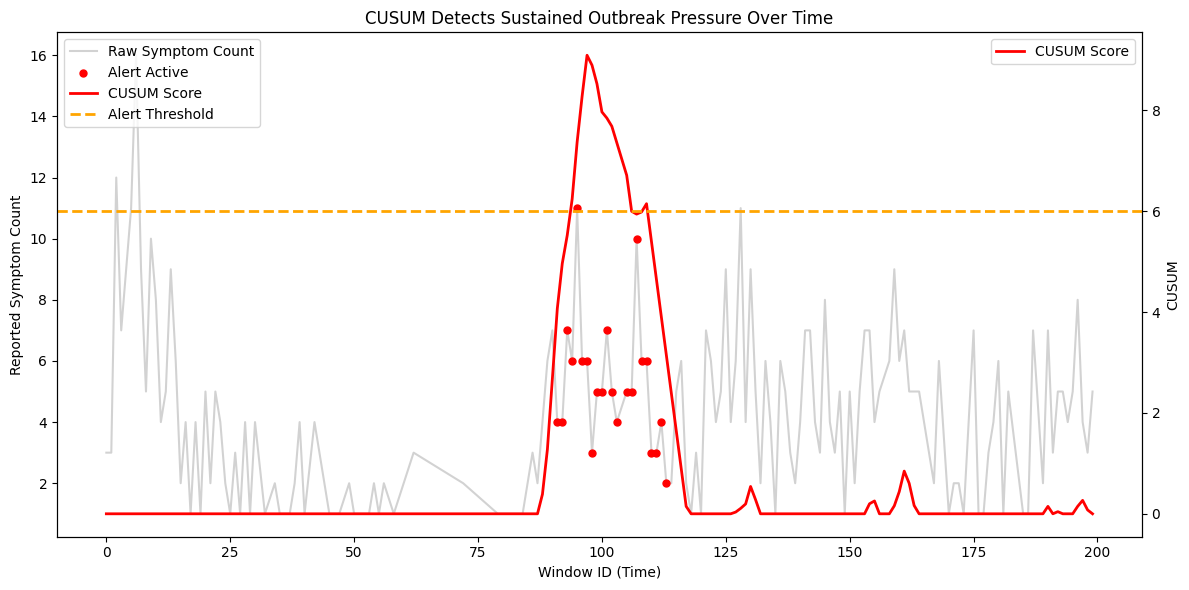

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for the specific location/symptom that had the outbreak
outbreak_df = agg_df3[
    (agg_df3['location'] == 'hyd') &
    (agg_df3['symptom'] == 'cold')
].sort_values('window_id')

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# -------------------------
# Plot 1: Raw Counts (Primary Y-axis)
# -------------------------
sns.lineplot(
    data=outbreak_df,
    x='window_id',
    y='count',
    ax=ax1,
    label='Raw Symptom Count',
    color='gray',
    alpha=0.35
)

ax1.set_xlabel("Window ID (Time)")
ax1.set_ylabel("Reported Symptom Count")

# -------------------------
# Plot 2: CUSUM (Secondary Y-axis)
# -------------------------
ax2 = ax1.twinx()

sns.lineplot(
    data=outbreak_df,
    x='window_id',
    y='cusum',
    ax=ax2,
    label='CUSUM Score',
    color='red',
    linewidth=2
)

# Alert threshold
ax2.axhline(
    y=6.0,
    color='orange',
    linestyle='--',
    linewidth=2,
    label='Alert Threshold'
)

ax2.set_ylabel("CUSUM")

# -------------------------
# Optional: Mark alert-active windows
# -------------------------
alert_df = outbreak_df[outbreak_df['alert']]

ax1.scatter(
    alert_df['window_id'],
    alert_df['count'],
    color='red',
    s=25,
    zorder=5,
    label='Alert Active'
)

# -------------------------
# Title & Legend
# -------------------------
plt.title("CUSUM Detects Sustained Outbreak Pressure Over Time")

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    loc='upper left'
)

plt.tight_layout()
plt.savefig("cusum_alert_chart.png")
plt.show()


In [49]:
# Find the (location, symptom) pair with the highest CUSUM
top_loc, top_sym = (
    agg_df3
    .groupby(['location', 'symptom'])['cusum']
    .max()
    .idxmax()
)

top_loc, top_sym


(np.str_('che'), np.str_('cold'))

In [50]:
outbreak_df = (
    agg_df3[
        (agg_df3['location'] == top_loc) &
        (agg_df3['symptom'] == top_sym)
    ]
    .sort_values('window_id')
)


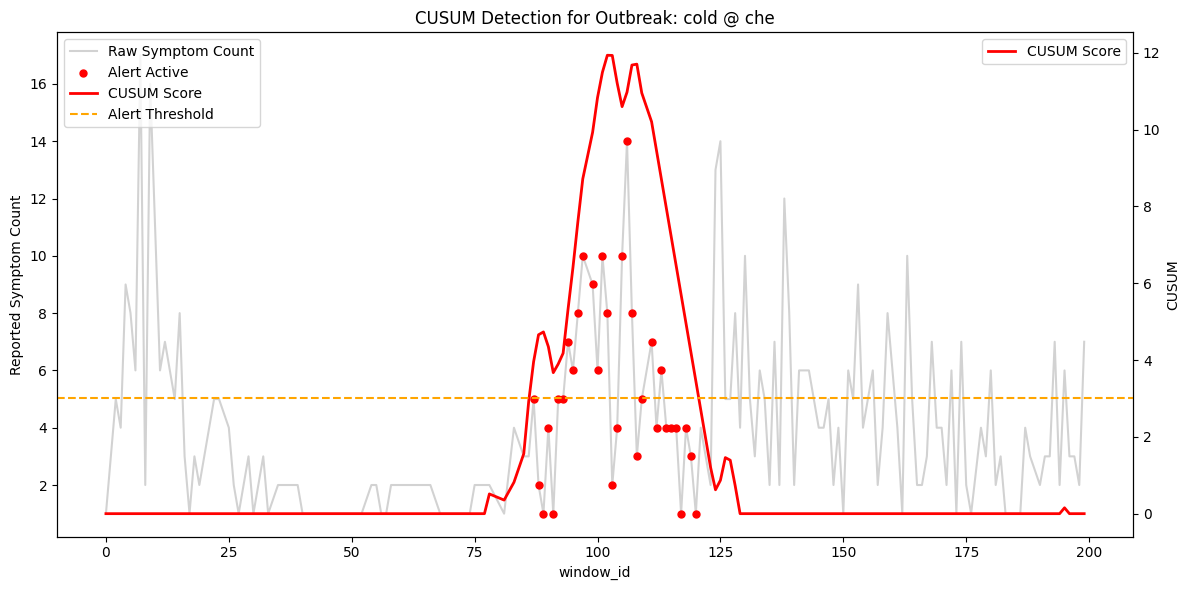

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(12, 6))

# Raw counts (reality)
sns.lineplot(
    data=outbreak_df,
    x='window_id',
    y='count',
    ax=ax1,
    color='gray',
    alpha=0.35,
    label='Raw Symptom Count'
)
ax1.set_ylabel("Reported Symptom Count")

# CUSUM (decision signal)
ax2 = ax1.twinx()
sns.lineplot(
    data=outbreak_df,
    x='window_id',
    y='cusum',
    ax=ax2,
    color='red',
    linewidth=2,
    label='CUSUM Score'
)
ax2.axhline(y=3.0, color='orange', linestyle='--', label='Alert Threshold')
ax2.set_ylabel("CUSUM")

# Alert markers
alert_df = outbreak_df[outbreak_df['alert']]
ax1.scatter(
    alert_df['window_id'],
    alert_df['count'],
    color='red',
    s=25,
    zorder=5,
    label='Alert Active'
)

plt.title(f"CUSUM Detection for Outbreak: {top_sym} @ {top_loc}")

# Merge legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()


In [52]:
import numpy as np

# -------------------------
# SEVERITY SCORE PARAMETERS
# -------------------------
CUSUM_MAX = 10.0# Max meaningful CUSUM (from empirical observation)

# -------------------------
# SEVERITY SCORE COMPUTATION
# -------------------------
# 1. Normalize CUSUM into [0, 1]
agg_df3['cusum_norm'] = np.clip(
 agg_df3['cusum'] / CUSUM_MAX,
 0,
 1
)

# 2. Apply curvature (square-root scaling)
#    - boosts early outbreak visibility
#    - saturates at high values
agg_df3['severity'] = 100 * np.sqrt(agg_df3['cusum_norm'])

# -------------------------
# OPTIONAL: SEVERITY BANDS (for interpretation)
# -------------------------
def severity_band(sev):
 if sev < 20:
  return "Normal"
 elif sev < 40:
  return "Mild"
 elif sev < 60:
  return "Elevated"
 elif sev < 80:
  return "High"
 else:
  return "Critical"

agg_df3['severity_band'] = agg_df3['severity'].apply(severity_band)

# -------------------------
# SANITY CHECK
# -------------------------
agg_df3[['cusum', 'severity', 'severity_band']].sort_values(
'severity', ascending=False
).head(10)

,cusum,severity,severity_band
5691,10.122464,100.0,Critical
3979,11.705056,100.0,Critical
5649,10.713162,100.0,Critical
4114,10.205056,100.0,Critical
3991,10.087294,100.0,Critical
3665,10.833702,100.0,Critical
3872,10.598841,100.0,Critical
3820,11.176743,100.0,Critical
3703,11.494597,100.0,Critical
5327,10.629481,100.0,Critical


In [53]:
# -------------------------
# ALERT STATE LOGIC (FIXED)
# -------------------------
ALERT_ON_THRESHOLD = 75   # or 60, depending on policy
ALERT_OFF_THRESHOLD = 50  # or 40

def alert_state_from_severity(severity_series):
    state = "NO_ALERT"
    states = []

    for sev in severity_series:
        if state == "NO_ALERT":
            if sev >= ALERT_ON_THRESHOLD:
                state = "ALERT_ACTIVE"

        elif state == "ALERT_ACTIVE":
            if sev <= ALERT_OFF_THRESHOLD:
                state = "NO_ALERT"

        states.append(state)

    return states


# Apply per (location, symptom) series using TRANSFORM
agg_df3['alert_state'] = (
    agg_df3
    .groupby(['location', 'symptom'])['severity']
    .transform(alert_state_from_severity)
)

# Binary flag for downstream use
agg_df3['alert_active'] = agg_df3['alert_state'] == "ALERT_ACTIVE"

# -------------------------
# SANITY CHECK
# -------------------------
agg_df3.loc[
    agg_df3['alert_active'],
    ['window_id', 'location', 'symptom', 'severity', 'alert_state']
].head(10)


,window_id,location,symptom,severity,alert_state
1080,31,mumb,asthma,76.834380,ALERT_ACTIVE
1097,32,mumb,asthma,79.739725,ALERT_ACTIVE
1114,33,mumb,asthma,79.563425,ALERT_ACTIVE
1129,33,che,asthma,75.347270,ALERT_ACTIVE
1146,34,mumb,asthma,74.701664,ALERT_ACTIVE
1154,34,che,asthma,73.018914,ALERT_ACTIVE
1186,35,mumb,asthma,69.500637,ALERT_ACTIVE
1201,35,che,asthma,69.038022,ALERT_ACTIVE
1239,36,mumb,asthma,63.877528,ALERT_ACTIVE
1251,36,che,asthma,65.883775,ALERT_ACTIVE


In [54]:
import json

def build_alert_payloads(df):
    """
    Scans the dataframe for active alerts and returns a list of
    JSON-formatted alert messages.
    """
    # 1. Filter for only rows where the alert is currently active
    active_alerts = df[df['alert_active'] == True].copy()

    # 2. We usually only want to alert on the LATEST window for each location/symptom
    latest_alerts = active_alerts.sort_values('window_id').groupby(['location', 'symptom']).tail(10)

    payloads = []

    for _, row in latest_alerts.iterrows():
        # Construct the JSON structure
        alert_message = {
            "status": "CRITICAL_OUTBREAK_DETECTED",
            "metadata": {
                "location": row['location'],
                "symptom_type": row['symptom'],
                "window_id": int(row['window_id']),
                "timestamp_processed": pd.Timestamp.now().isoformat()
            },
            "metrics": {
                "severity_score": round(float(row['severity']), 2),
                "severity_band": row['severity_band'],
                "cusum_value": round(float(row['cusum']), 2),
                "z_score": round(float(row['z_score']), 2)
            },
            "display_message": (
                f"Alert! High symptom pressure for '{row['symptom']}' "
                f"detected in {row['location']}. Severity: {row['severity_band']}."
            )
        }
        payloads.append(alert_message)

    return payloads

# Generate the JSON list
json_alerts = build_alert_payloads(agg_df3)

# Print as a formatted JSON string (for your chatbot team)
with open("j1.json", "w", encoding="utf-8") as f:
    json.dump(json_alerts, f, indent=2)



In [55]:
from google.colab import files
files.download("j1.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>